<a href="https://colab.research.google.com/github/maxskoda/NR_datareduction/blob/main/OleicAcid_onSi_May21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install refnx

     |████████████████████████████████| 3.4MB 4.2MB/s 


In [4]:
! git clone 'https://github.com/maxskoda/NR_datareduction/'

Cloning into 'NR_datareduction'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 227 (delta 3), reused 215 (delta 2), pack-reused 0
Receiving objects: 100% (227/227), 704.68 KiB | 1.58 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [63]:
from numpy import genfromtxt

with open('/content/NR_datareduction/RB2010748/BackgroundSub_ASCII/BgSub_IvsQ_62459_62460.dat') as f:
  x = []
  y = []
  e = []
  for line in f:
    if float(line.split('\t')[1]) > 0:
      xx,yy,ee = line.split('\t')
      x.append(xx)
      y.append(yy)
      e.append(ee)
result = (x, y, e)
print(result)
# result = np.ndarray(points)

# res = genfromtxt('/content/NR_datareduction/RB2010748/BackgroundSub_ASCII/BgSub_IvsQ_62459_62460.dat', delimiter='\t')
# result = np.array(res, dtype=np.float)
# print(result[0])

(['6.532015878499265e-03', '6.696661870732718e-03', '6.865457929846407e-03', '7.038508662426115e-03', '7.215921311771227e-03', '7.397805824355733e-03', '7.584274917964443e-03', '7.775444151546655e-03', '7.971431996830539e-03', '8.172359911742651e-03', '8.378352415678036e-03', '8.589537166667615e-03', '8.806045040490639e-03', '9.028010211781245e-03', '9.255570237179402e-03', '9.488866140577746e-03', '9.728042500517150e-03', '9.973247539785185e-03', '1.022463321727301e-02', '1.048235532214759e-02', '1.074657357039764e-02', '1.101745170381309e-02', '1.129515759145940e-02', '1.157986333370973e-02', '1.187174536889921e-02', '1.217098458266769e-02', '1.247776642005841e-02', '1.279228100044240e-02', '1.311472323533955e-02', '1.344529294920952e-02', '1.378419500328729e-02', '1.413163942254015e-02', '1.448784152582470e-02', '1.485302205932464e-02', '1.522740733335198e-02', '1.561122936259645e-02', '1.600472600991005e-02', '1.640814113371585e-02', '1.682172473913229e-02', '1.724573313290685e-02'

In [ ]:
pip install numpy

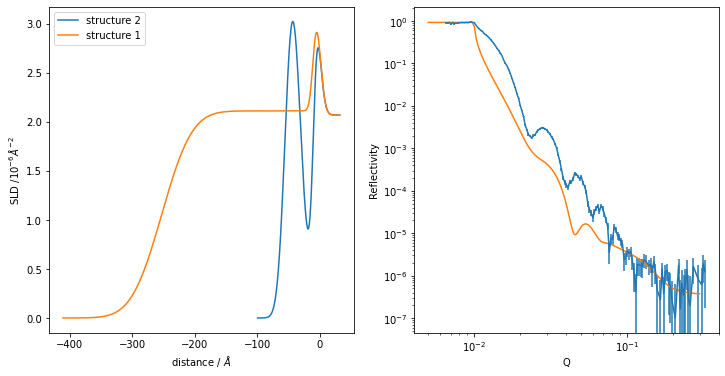

In [64]:
#@title Model parameters 
path = "/content/NR_datareduction/RB2010748/BackgroundSub_ASCII/" #@param {type:"string"}
file_name = "BgSub_IvsQ_62459_62460.dat" #@param {type:"string"}
film_thickness =  242.8#@param {type:"number"}
OA_layer_thick = 21.3917 #@param {type:"number"}
SO_layer_thick = 23.0764 #@param {type:"number"}
stack_repeats =  0#@param {type:"integer"}

import matplotlib.pyplot as plt
import numpy as np
#import os.path
import time as tm
import pandas as pd
import pickle
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



import refnx, scipy

# the analysis module contains the curvefitting engine
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, process_chain, Transform

# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import SLD, MixedReflectModel, ReflectModel, Structure, Stack

# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset


data_DiscA_1 = refnx.dataset.Data1D(result) #ReflectDataset(result)#path+file_name, mask=mask)
data_DiscA_1.name = "1pc_2000RPM"

#get_ipython().run_line_magic('matplotlib', 'notebook')
#fig, ax = plt.subplots()
# data_DiscA_1.plot()
# plt.xlabel('Q')
# plt.ylabel('Reflectivity')
# plt.yscale('log')
# plt.xscale('log')

## create slabs
si = SLD(2.07, name='Si')
sio2 = SLD(3.47, name='SiO2')
film = SLD(2.11237, name='film')
air = SLD(0.0, name='air')
OA = SLD(4.12, name='OA')#
SO = SLD(0.521811, name='SO')

# first number is thickness, second number is roughness
# a native oxide layer
sio2_layer = sio2(9.72956, 5.0)

# the film of interest
film_layer = film(film_thickness, 38.22)
OA_layer = OA(OA_layer_thick,10)
SO_layer = SO(SO_layer_thick,10)

sio2_layer.thick.setp(bounds=(5, 100), vary=True)
sio2_layer.rough.setp(bounds=(1, 30), vary=True)

film_layer.thick.setp(bounds=(100, 550), vary=True)
film_layer.sld.real.setp(bounds=(0.1, 4), vary=True)
film_layer.rough.setp(bounds=(0.1, 45), vary=True)

OA_layer.thick.setp(bounds=(18, 25), vary=True)
OA_layer.sld.real.setp(bounds=(0, 6.5), vary=True) #
OA_layer.rough.setp(bounds=(5, 15), vary=True)

SO_layer.thick.setp(bounds=(18, 25), vary=True)
SO_layer.sld.real.setp(bounds=(0.2, 6.5), vary=True)
SO_layer.rough.setp(bounds=(5, 15), vary=True)

si_back = si(0,6.8)

# define which model to use ***CHANGE THIS***
model_no = 1
MCMC = False

if model_no == 1:
    # Make a multilayer by using a Stack Component
    stack = Stack(components=OA_layer|SO_layer, repeats=stack_repeats)
    bilayer = Stack(components=OA_layer|SO_layer, repeats=1)
    #stack |= OA_layer
    #stack |= SO_layer
    # stack.repeats = 10.0
    q_shift = Parameter(2e-4, 'q_shift')
    stack.repeats.setp(bounds=(2,10),vary=True) # vary repeats
    q_shift.setp(bounds=(1e-5,1e-3), vary=True)
    # assemble the structure
    structure1 = air | film_layer | sio2_layer | si_back 
    structure2 = air | stack | sio2_layer | si_back
    
    
    
    model = MixedReflectModel((structure1,structure2), scales=(0.87,0.06), bkg=3.67e-7, dq=2.5, q_offset=q_shift)
    model.scales[0].setp(bounds=(0.0, 1.2), vary=True)
    model.scales[1].setp(bounds=(0.0, 1.2), vary=True)
    model.bkg.setp(bounds=(1e-9, 9e-6), vary=True)

elif model_no == 7:
    # Make a multilayer by using a Stack Component
    stack = Stack(components=OA_layer|SO_layer, repeats=6)
    #stack |= OA_layer
    #stack |= SO_layer
    #stack.repeats = 10.0
    stack.repeats.setp(bounds=(2,6),vary=True) # vary repeats
    # assemble the structure
    structure1 = air | film_layer | stack | sio2_layer | si_back 
    
    # now only 1 structure to model
    model = ReflectModel(structure1,scale=1,bkg=3e-7, dq=2.5)
    model.scale.setp(bounds=(0,1.2),vary=True)
    model.bkg.setp(bounds=(1e-9,1e-6),vary=True)
    
elif model_no == 8:
    # Make a multilayer by using a Stack Component
    stack = Stack(components=OA_layer|SO_layer, repeats=6)
    #stack |= OA_layer
    #stack |= SO_layer
    #stack.repeats = 10.0
    stack.repeats.setp(bounds=(2,6),vary=True) # vary repeats
    # assemble the structure
    structure1 = air | stack | film_layer | sio2_layer | si_back 
    
    # now only 1 structure to model
    model = ReflectModel(structure1,scale=1,bkg=3e-7, dq=2.5)
    model.scale.setp(bounds=(0,1.2),vary=True)
    model.bkg.setp(bounds=(1e-9,1e-6),vary=True)

# check model

q = np.linspace(0.005, 0.3, 1001)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

# plot the SLD profile
if model_no == 1:
    ax1.plot(*structure2.sld_profile(align=-1),label='structure 2')
ax1.plot(*structure1.sld_profile(align=-1),label='structure 1')
ax1.set_ylabel('SLD /$10^{-6} \AA^{-2}$')
ax1.set_xlabel('distance / $\AA$');
ax1.legend()

data_DiscA_1.plot(plt)
ax2.plot(q, model(q))
ax2.set_xlabel('Q')
ax2.set_ylabel('Reflectivity')
ax2.set_yscale('log')
ax2.set_xscale('log')


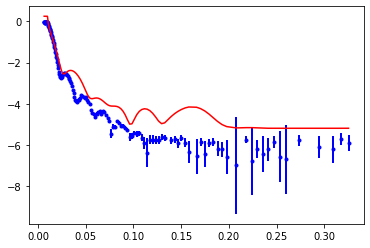

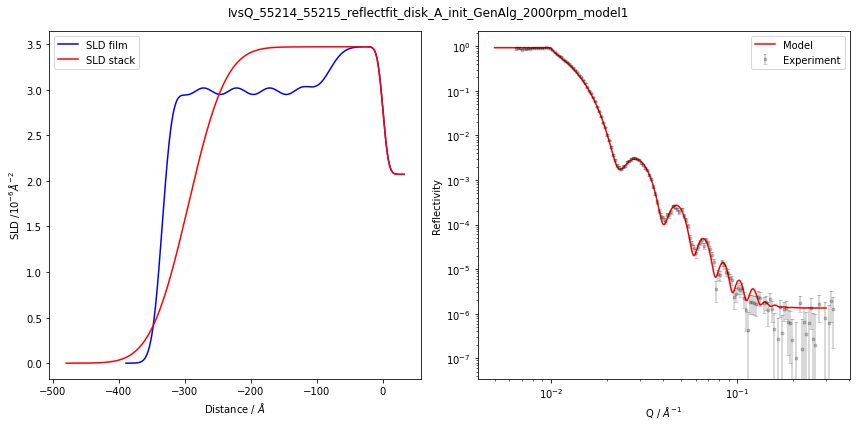

Fitted Chi2: 190.7120944574306
That took 4.82 seconds!


In [66]:
start_time = tm.time()
## create 'objective'
objective = Objective(model, data_DiscA_1, transform=Transform('logY'))
# print(objective.chisqr(), objective.logp(), objective.logl(), objective.logpost())
objective.plot()


# In[74]:


## do the fit and plot result
fitter = CurveFitter(objective)
fitter.fit('least_squares') #least_squares


# In[75]:

#print(objective.chisqr())

# In[77]:


#objective.plot()
#print(objective)
#%%
#MCMC sampling
if MCMC == True:
    fitter.sample(400)
    fitter.reset()
    
    res = fitter.sample(15,nthin=100)

# In[79]:


# check model

q = np.linspace(0.005, 0.3, 1001)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

# plot the SLD profile
if model_no == 1:
    ax1.plot(*structure2.sld_profile(align=-1),'b-',label='SLD film')
ax1.plot(*structure1.sld_profile(align=-1),'r-',label='SLD stack')
ax1.set_ylabel('SLD /$10^{-6} \AA^{-2}$')
ax1.set_xlabel('Distance / $\AA$');

#data_DiscA_1.plot(plt)
ax2.errorbar(data_DiscA_1.x,data_DiscA_1.y,yerr=data_DiscA_1.y_err,
             linestyle='None',marker='.',color=(0,0,0,0.2),capsize=2,label='Experiment')
ax2.plot(q, model(q),'r-',label='Model')
ax2.set_xlabel('Q / $\AA^{-1}$')
ax2.set_ylabel('Reflectivity')
ax2.set_yscale('log')
ax2.set_xscale('log')

ax1.legend()
ax2.legend()

fig.suptitle('IvsQ_55214_55215_reflectfit_disk_A_init_GenAlg_2000rpm_model{}'.format(model_no))
fig.tight_layout()
fig.subplots_adjust(top=0.923)
#plt.savefig('figures/fitted_data/55159_55160_reflectfit_disk_A_dry_beforeozone_GenAlg_2000rpm_model{}.png'.format(model_no),dpi=200)
plt.show()

#%%
'''
Getting fitted params with errors into a readable dictionary
'''

param_names = []
param_vals = []
param_err = []

# capture fitted parameter name, output and std error
params = objective.parameters.flattened()
for i in np.arange(len(params)):
    param_names.append(params[i].name) # str
    param_vals.append(params[i].value) # int
    
    error = params[i].stderr
    if error == None:
        error = 0
    param_err.append(error) # int

# stick vals and errors together
val_err_array = np.column_stack((param_vals,param_err))
    
# build results dictionary key --> param, value --> array(value,error)
fitted_params = {}
count = 0
for ind, name in enumerate(param_names):   
    if name == 'scale' and count == 0:
        count = 1
        fitted_params[name] = val_err_array[ind,:]
    elif name == 'scale':
        fitted_params[name+'_2nd'] = val_err_array[ind,:]
    else:
        fitted_params[name] = val_err_array[ind,:]
if model_no == 1:        
    params_ofinterest = ['OA - thick','OA - sld','OA - rough','SO - thick','SO - sld','SO - rough','film - thick','film - sld','film - rough','repeats','scale','scale_2nd']
elif model_no in [7,8]:
    params_ofinterest = ['OA - thick','OA - sld','OA - rough','SO - thick','SO - sld','SO - rough','film - thick','film - sld','film - rough','repeats','scale']
param_val_select = []
for valname in params_ofinterest:
    param_val_select.append(fitted_params[valname])
output = np.column_stack((params_ofinterest,param_val_select))

output_df = pd.DataFrame(output)
#if MCMC == True:
#    output_df.to_csv('55159_55160_fitted_params_GenAlg_MCMC_model{}.csv'.format(model_no),index_label=False)    
#else:
#    output_df.to_csv('55159_55160_fitted_params_GenAlg_model{}.csv'.format(model_no),index_label=False)
# #pickle model and objective
filename = '55214_55215_model{}.pkl'.format(model_no)
#if MCMC == True:
#    filename = '51159_55160_DA2000_beforeO3_MCMC_model{}.pkl'.format(model_no)

with open(filename,'wb+') as f:
   pickle.dump(objective,f)    

#%%
'''
# To read in "pickled" objective file from MCMC sampling
with open('51159_55160_DA2000_beforeO3_MCMC_model1.pkl', 'rb') as f:
    restored_objective = pickle.load(f)

#restored_objective.plot(samples=300)
structure1 = restored_objective.model.structures[0]
structure2 = restored_objective.model.structures[1]
model = restored_objective.model

# plot the output, visualising the variation in the model
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(8,3))
 
plt.sca(axs[0]) # set current axis (sca)
 
structure1.plot(samples=300,fig=fig)
structure2.plot(samples=300,fig=fig)
axs[0].set_xlabel('$z / \AA$')  
axs[0].set_ylabel('$SLD / x10^{-6}\AA^{-2}$')  

plt.sca(axs[1])
restored_objective.plot(samples=300,fig=fig)
#axs[1].set_yscale('log')
#axs[1].set_xscale('log')
axs[1].set_ylabel('Reflectivity')
axs[1].set_xlabel('$Q / \AA^{-1}$')

fig.tight_layout()
#plt.savefig('55159_55160_initial_fit_withMCMC.png')
plt.show()

# group params into a dict to make it readable (save as .csv as before?)

param_names = []
param_vals = []
param_err = []

# capture fitted parameter name, output and std error
params = restored_objective.parameters.flattened()
for i in np.arange(len(params)):
    param_names.append(params[i].name) # str
    param_vals.append(params[i].value) # int
    
    error = params[i].stderr
    if error == None:
        error = 0
    param_err.append(error) # int

# stick vals and errors together
val_err_array = np.column_stack((param_vals,param_err))
    
# build results dictionary key --> param, value --> array(value,error)
fitted_params = {}
count = 0
for ind, name in enumerate(param_names):   
    if name == 'scale' and count == 0:
        count = 1
        fitted_params[name] = val_err_array[ind,:]
    elif name == 'scale':
        fitted_params[name+'_2nd'] = val_err_array[ind,:]
    else:
        fitted_params[name] = val_err_array[ind,:]

'''

#%%
end_time = tm.time()
print('Fitted Chi2:',objective.chisqr())
print('That took {:.2f} seconds!'.format(end_time-start_time))


In [67]:
print(objective.varying_parameters())
# output_df

________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.475599 +/- 0.0763, bounds=[0.0, 1.2]>
<Parameter:    'scale'    , value=0.450537 +/- 0.0759, bounds=[0.0, 1.2]>
<Parameter:     'bkg'     , value=1.33664e-06 +/- 1.61e-07, bounds=[1e-09, 9e-06]>
<Parameter:   'q_shift'   , value=0.000101268 +/- 1.98e-05, bounds=[1e-05, 0.001]>
<Parameter:'film - thick' , value=210.791 +/- 64.7 , bounds=[100.0, 550.0]>
<Parameter: 'film - sld'  , value=3.46823 +/- 0.0614, bounds=[0.1, 4.0]>
<Parameter:'film - rough' , value=45 +/- 9.88 , bounds=[0.1, 45.0]>
<Parameter:'SiO2 - thick' , value=83.9332 +/- 51.1 , bounds=[5.0, 100.0]>
<Parameter:'SiO2 - rough' , value=18.3333 +/- 33.2 , bounds=[1.0, 30.0]>
<Parameter:   'repeats'   , value=4.7977 +/- 2.1e-14, bounds=[2.0, 10.0]>
<Parameter: 'OA - thick'  , value=25 +/- 97.9 , bounds=[18.0, 25.0]>
<Parameter:  'OA - sld'   , value=3.10411 +/- 2.68 , bounds=[0.0, 6.5]